In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pycountry
import string
import nltk
import unidecode
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.impute import SimpleImputer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
from gensim import corpora
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("C:/Users/krist/Desktop/Python learning/datasets/ufo_train.csv") 

In [4]:
df.head()

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude,Duration Category
0,1,Chester,VA,2019-12-12T18:43:00,light,My wife was driving southeast on a fairly popu...,2019-12-22T00:00:00,37.343152,-77.408582,seconds
1,2,Rocky Hill,CT,2019-03-22T18:30:00,circle,I think that I may caught a UFO on the NBC Nig...,2019-03-29T00:00:00,41.664800,-72.639300,seconds
2,3,NaN,NaN,NaN,NaN,I woke up late in the afternoon 3:30-4pm. I w...,NaN,NaN,NaN,Unknown
3,4,Ottawa,ON,2019-04-17T02:00:00,teardrop,I was driving towards the intersection of fall...,2019-04-18T00:00:00,45.381383,-75.708501,seconds
4,5,Peoria,NY,2009-03-15T18:00:00,cigar,"In Peoria, Arizona, I saw a cigar shaped craft...",2019-04-18T00:00:00,NaN,NaN,minutes


In [5]:
missing_prop=df.isna().sum()/len(df)
missing_prop[missing_prop>0].sort_values(ascending=False)

city_latitude     0.187549
city_longitude    0.187549
state             0.065008
shape             0.023220
date_time         0.014213
posted            0.014213
city              0.002468
text              0.000539
dtype: float64

In [6]:
df.dtypes

Text_ID                int64
city                  object
state                 object
date_time             object
shape                 object
text                  object
posted                object
city_latitude        float64
city_longitude       float64
Duration Category     object
dtype: object

In [7]:
df.shape

(70499, 10)

In [3]:
df=df.drop_duplicates()

In [4]:
#convert to datetime format
df['date_time']=pd.to_datetime(df['date_time'],errors='coerce')
df['posted']=pd.to_datetime(df['posted'],'coerce')
df['text']=df['text'].astype(str)

In [5]:
#trying to get cities from city that is not in USA (it is separated with '()')
df['city_clean']=df['city'].str.split('(',1).str[0]

In [6]:
df['city_clean']=df['city_clean'].astype(str)
df['city_clean']=df['city_clean'].apply(lambda x: x.strip())

In [7]:
df['country']=np.where(df['state'].isnull(),df['city'].str.split('(',1).str[1].str.strip(')'),np.nan)

In [8]:
import pandasql as ps

q1 = """SELECT a.*,  
        CASE WHEN state in ('ON','QC','NL','PE','NS','NB','MB','SK','AB','BC','YT','NT','NU') THEN 'Canada' 
                 WHEN state IS NOT NULL THEN 'United States' 
                 ELSE country END as country2
from df a """

df= ps.sqldf(q1, locals())

In [9]:
df.drop('country',axis=1,inplace=True)

In [10]:
df=df.rename(columns={'country2':"country"})

In [11]:
country_list=[]
for x in pycountry.countries:
    country_list.append(x.name)

In [12]:
def country_search(row):
    if row in country_list:
        return row
    else:
        return 'Not found'
df["country_python"]=df["country"].apply(country_search)  

In [13]:
#need to convert one more time since SQL query changes its data type
df['date_time']=pd.to_datetime(df['date_time'],errors='coerce')
df['posted']=pd.to_datetime(df['posted'],'coerce')

In [14]:
#dropping NaN rows for date_time since imputing isn't the best idea as data is not missing at random
df=df[df['date_time'].notnull()]

In [15]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LAPTOP-JQCGOBOD;'
                      'Database=ufo;'
                      'Trusted_Connection=yes;'
                      'Application_intent=ReadOnly')

In [16]:
cursor=conn.cursor()

cursor.execute('SELECT * FROM ufo.dbo.ufo_weather2')    
               
ufo_weather = cursor.fetchall()
cursor.close()

In [17]:
df_full = pd.DataFrame.from_records(ufo_weather, columns=['Text_ID'
                                                         ,'date_time'
                                                         ,'posted'
                                                         ,'city'
                                                         ,'state'
                                                         ,'shape'
                                                         ,'Duration Category'
                                                         ,'city_latitude'
                                                         ,'city_longitude'
                                                         ,'city_clean'
                                                         ,'country'
                                                         ,'country_python'
                                                         ,'sAddress'
                                                         ,'fTemp'
                                                         ,'precip'
                                                         ,'visibility'
                                                         ,'sConditions'
                                                           ])

In [19]:
df_full[df_full['city_clean']=='Kiev']

,Text_ID,date_time,posted,city,state,shape,Duration Category,city_latitude,city_longitude,city_clean,country,country_python,sAddress,fTemp,precip,visibility,sConditions
15920,16398,2009-09-11 21:55:00,2009-12-12,Kiev (Ukraine),,fireball,minutes,50.4506,30.5243,Kiev,Ukraine,Ukraine,"Kiev,Ukraine",20.8,0.0,17.4,Clear
31958,32639,2011-11-09 12:00:00,2011-12-12,Kiev (Ukraine),,flash,seconds,50.4506,30.5243,Kiev,Ukraine,Ukraine,"Kiev,Ukraine",5.0,1.0,8.9,Drizzle
31959,32640,2011-11-09 12:00:00,2011-12-12,Kiev (Ukraine),,flash,minutes,50.4506,30.5243,Kiev,Ukraine,Ukraine,"Kiev,Ukraine",5.0,1.0,8.9,Drizzle


In [18]:
#replacing blanks, empty strings wih NaN
df_full=df_full.replace(r'^\s*$',np.NaN,regex=True)

In [19]:
df_new=df.merge(df_full,how='left',on=['Text_ID','date_time','posted','city','state','Duration Category','shape','city_clean','country','country_python'])

In [309]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_new[df_new['city_clean']=='Kiev']

,Text_ID,state,date_time,shape,text,posted,Duration Category,city_clean,country_python,fTemp,precip,visibility,sConditions
15920,16398,Outside US/Canada,2009-09-11 21:55:00,fireball,red light over Kiev (Ukraine) Dear ufologists!...,2009-12-12,minutes,Kiev,Ukraine,20.8,0.0,17.4,Clear
31958,32639,Outside US/Canada,2011-11-09 12:00:00,flash,Blue flash lights over the top of the Kiev pla...,2011-12-12,seconds,Kiev,Ukraine,5.0,1.0,8.9,Drizzle
31959,32640,Outside US/Canada,2011-11-09 12:00:00,flash,"BLUE DOTS OVER KYIV PLANETARIUM, UKRAINE, KYIV...",2011-12-12,minutes,Kiev,Ukraine,5.0,1.0,8.9,Drizzle


In [20]:
df_new.drop(['city_latitude_x','city_longitude_x','sAddress','country','city'],axis=1,inplace=True)

In [21]:
df_new=df_new.rename(columns={'city_latitude_y':"city_latitude",'city_longitude_y':'city_longitude'})

In [22]:
#fill in NA for state with indicator that it is not United States/Canada
df_new['state']=df_new['state'].fillna('Outside US/Canada')

In [23]:
df_new.drop(['city_latitude','city_longitude'],axis=1,inplace=True)
df_new=df_new.drop_duplicates()

In [24]:
df_geo = pd.read_csv("C:/Users/krist/Desktop/Python learning/datasets/ufo_geo_enriched.csv") 

In [25]:
q1 = """SELECT DN.*,  
          AIRPORT_DISTANCE,
          AIRPORT_AZIMUTH,
          WATER_BODY_DISTANCE,
          WATER_BODY_AZIMUTH,
          WATER_BODY_NAME,
          AIRPORT_NAME,
          URBAN_AREA,
          CASE WHEN AIRPORT_NAME IS NOT NULL THEN 1 ELSE 0 END AS bIsAirport ,
          CASE WHEN WATER_BODY_FID=-1 THEN 0 ELSE 1 END AS bIsNearWater,
          CASE WHEN cast(URBAN_AREA_ID as int)=-1 AND DN.state !='Outside US/Canada' THEN 'rural'
               WHEN (cast(URBAN_AREA_ID as int)=-1 AND DN.state='Outside US/Canada') OR (cast(URBAN_AREA_ID as int) IS NULL) THEN 'Unknown'
               ELSE 'urban' END as bIsRuralArea
         
          
from df_new DN
left join df_geo as DG ON DN.Text_ID=DG.Text_ID"""

df_new= ps.sqldf(q1, locals())

In [26]:
#need to convert one more time since SQL query change its data type
df_new['date_time']=pd.to_datetime(df_new['date_time'],errors='coerce')
df_new['posted']=pd.to_datetime(df_new['posted'],'coerce')

In [27]:
missing_prop=df_new.isna().sum()/len(df_new)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA             40.224758
WATER_BODY_NAME        22.783717
shape                   2.259090
fTemp                   1.020188
precip                  1.020188
visibility              1.020188
sConditions             1.020188
AIRPORT_NAME            0.282027
AIRPORT_DISTANCE        0.277710
AIRPORT_AZIMUTH         0.277710
WATER_BODY_DISTANCE     0.277710
WATER_BODY_AZIMUTH      0.277710
dtype: float64

In [27]:
# creating surrogates for missing values except columns that I won't take for modelling
columns=list(set(df_new.columns)) #-set(df_new[['URBAN_AREA','AIRPORT_NAME']].columns))

for col in df_new[columns]:
    if df_new[col].isna().sum() != 0: 
        df_new[col + '_surrogate'] = df_new[col].isna().astype(int)

In [29]:
df_new.columns

Index(['Text_ID', 'state', 'date_time', 'shape', 'text', 'posted',
       'Duration Category', 'city_clean', 'country_python', 'fTemp', 'precip',
       'visibility', 'sConditions', 'AIRPORT_DISTANCE', 'AIRPORT_AZIMUTH',
       'WATER_BODY_DISTANCE', 'WATER_BODY_AZIMUTH', 'WATER_BODY_NAME',
       'AIRPORT_NAME', 'URBAN_AREA', 'bIsAirport', 'bIsNearWater',
       'bIsRuralArea', 'AIRPORT_AZIMUTH_surrogate', 'shape_surrogate',
       'WATER_BODY_DISTANCE_surrogate', 'AIRPORT_DISTANCE_surrogate',
       'visibility_surrogate', 'WATER_BODY_AZIMUTH_surrogate',
       'precip_surrogate', 'WATER_BODY_NAME_surrogate',
       'sConditions_surrogate', 'fTemp_surrogate', 'AIRPORT_NAME_surrogate',
       'URBAN_AREA_surrogate'],
      dtype='object')

In [28]:
date=pd.to_datetime(df_new['date_time']).dt.date
posted=pd.to_datetime(df_new['posted']).dt.date

df_new['delta_posted_event'] = (posted - date).dt.days

In [31]:
missing_prop=df_new.isna().sum()/len(df_new)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA             40.224758
WATER_BODY_NAME        22.783717
shape                   2.259090
fTemp                   1.020188
precip                  1.020188
visibility              1.020188
sConditions             1.020188
AIRPORT_NAME            0.282027
AIRPORT_DISTANCE        0.277710
AIRPORT_AZIMUTH         0.277710
WATER_BODY_DISTANCE     0.277710
WATER_BODY_AZIMUTH      0.277710
dtype: float64

In [29]:
df_new['ufo_year'] = df_new['date_time'].dt.year
df_new['ufo_month'] = df_new['date_time'].dt.month
df_new['ufo_day'] = df_new['date_time'].dt.day
df_new['ufo_hour'] = df_new['date_time'].dt.hour
df_new['ufo_minute'] = df_new['date_time'].dt.minute
df_new['ufo_weekday_number'] = df_new['date_time'].dt.dayofweek #Sunday 6
df_new['ufo_weekday_name'] = df_new['date_time'].dt.day_name()

In [30]:
def IsWeekend(row):
    if row in range (5,6):
        return 1
    else:
        return 0
df_new["IsWeekend"]=df_new['ufo_weekday_number'].apply(IsWeekend) 

In [31]:
def season_search(row):
    if row in range (3,6):
        return 'Spring'
    elif row in range(6,9):
        return 'Summer'
    elif row in range(9,12):
        return 'Fall'
    else:
        return 'Winter'
df_new["season"]=df_new["ufo_month"].apply(season_search)  

In [32]:
def time_interval(row):
    if row in range (0,5):
        return 'Night'
    elif row in range(5,12):
        return 'Morning'
    elif row in range(11,17):
        return 'Afternoon'
    else:
        return 'Evening'
df_new["time_of_day"]=df_new["ufo_hour"].apply(time_interval)  

In [33]:
# creating cyclical hour feature.
df_new['ufo_month_sin'] = np.sin(df_new['ufo_month'] * (2. * np.pi / 12 ))
df_new['ufo_month_cos'] = np.cos(df_new['ufo_month'] * (2. * np.pi / 12 ))

# creating cyclical minute feature.
df_new['ufo_day_sin'] = np.sin(df_new['ufo_day'] * (2. * np.pi / 30 ))
df_new['ufo_day_cos'] = np.cos(df_new['ufo_day'] * (2. * np.pi / 30 ))

# creating cyclical month days feature.
df_new['ufo_hour_sin'] = np.sin((df_new['ufo_hour'] - 1) * (2. * np.pi / 24 ))
df_new['ufo_hour_cos'] = np.cos((df_new['ufo_hour'] - 1) * (2. * np.pi / 24 ))

# creating cyclical minute days feature.
df_new['ufo_minute_sin'] = np.sin((df_new['ufo_minute'] - 1) * (2. * np.pi / 60 ))
df_new['ufo_minute_cos'] = np.cos((df_new['ufo_minute'] - 1) * (2. * np.pi / 60 ))

# creating cyclical minute days feature.
df_new['ufo_weekday_sin'] = np.sin((df_new['ufo_weekday_number'] - 1) * (2. * np.pi / 7 ))
df_new['ufo_weekday_cos'] = np.cos((df_new['ufo_weekday_number'] - 1) * (2. * np.pi / 7 ))

In [66]:
missing_prop=df_new.isna().sum()/len(df_new)
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA             0.402248
WATER_BODY_NAME        0.227837
shape                  0.022591
fTemp                  0.010202
precip                 0.010202
visibility             0.010202
sConditions            0.010202
AIRPORT_NAME           0.002820
AIRPORT_DISTANCE       0.002777
AIRPORT_AZIMUTH        0.002777
WATER_BODY_DISTANCE    0.002777
WATER_BODY_AZIMUTH     0.002777
dtype: float64

In [34]:
df_new['WATER_BODY_NAME']=df_new['WATER_BODY_NAME'].fillna('Unknown')

In [573]:
 with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_new[df_new['city_clean']=='Kiev']

,Text_ID,state,date_time,shape,text,posted,Duration Category,city_clean,country_python,sConditions,AIRPORT_DISTANCE,AIRPORT_AZIMUTH,WATER_BODY_DISTANCE,WATER_BODY_AZIMUTH,WATER_BODY_NAME,bIsNearWater,bIsRuralArea,ufo_year,ufo_month,ufo_day,ufo_hour,ufo_minute,ufo_weekday_number,ufo_weekday_name,season,time_of_day,ufo_month_sin,ufo_month_cos,ufo_day_sin,ufo_day_cos,ufo_hour_sin,ufo_hour_cos,ufo_minute_sin,ufo_minute_cos,ufo_weekday_sin,ufo_weekday_cos,fTemp_surrogate,shape_surrogate,WATER_BODY_NAME_surrogate,AIRPORT_NAME_surrogate,AIRPORT_AZIMUTH_surrogate,sConditions_surrogate,visibility_surrogate,URBAN_AREA_surrogate,precip_surrogate,WATER_BODY_AZIMUTH_surrogate,sentiment,IsWeekend,fTemp_winsorized,precip_winsorized,visibility_winsorized,delta_posted_event_winsorized
15920,16398,Outside US/Canada,2009-09-11 21:55:00,ball,red light over Kiev (Ukraine) Dear ufologists!...,2009-12-12,minutes,Kiev,Ukraine,Clear,1,-136.4,1,0.0,Unknown,0,Unknown,2009,9,11,21,55,4,Friday,Fall,Evening,-1.0,-0.0,0.7,-0.7,-0.9,0.5,-0.6,0.8,0.4,-0.9,0,0,1,0,0,0,0,1,0,0,1,0,Warm,Very Low,Very Low,92
31958,32639,Outside US/Canada,2011-11-09 12:00:00,light,Blue flash lights over the top of the Kiev pla...,2011-12-12,seconds,Kiev,Ukraine,Drizzle,1,-136.4,1,0.0,Unknown,0,Unknown,2011,11,9,12,0,2,Wednesday,Fall,Afternoon,-0.5,0.9,1.0,-0.3,0.3,-1.0,-0.1,1.0,0.8,0.6,0,0,1,0,0,0,0,1,0,0,1,0,Warm,Very Low,Very Low,33
31959,32640,Outside US/Canada,2011-11-09 12:00:00,light,"BLUE DOTS OVER KYIV PLANETARIUM, UKRAINE, KYIV...",2011-12-12,minutes,Kiev,Ukraine,Drizzle,1,-136.4,1,0.0,Unknown,0,Unknown,2011,11,9,12,0,2,Wednesday,Fall,Afternoon,-0.5,0.9,1.0,-0.3,0.3,-1.0,-0.1,1.0,0.8,0.6,0,0,1,0,0,0,0,1,0,0,1,0,Warm,Very Low,Very Low,33


In [35]:
df_new['shape'] = np.where((df_new['shape']=='circle'),'disk',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'oval'),'disk',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'round'),'disk',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'sphere'),'ball',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'fireball'),'ball',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'cigar'),'cylinder',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'cone'),'cylinder',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'rectangle'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'chevron'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'triangle'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'diamond'),'geometric',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'cross'),'geometric',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'formation'),'changing',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'unknown'),'other',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'egg'),'other',df_new['shape'])
df_new['shape'] = np.where((df_new['shape'] == 'teardrop'),'other',df_new['shape'])

df_new['shape'] = np.where((df_new['shape'] == 'flash'),'light',df_new['shape'])

df_new['shape']=df_new['shape'].fillna('missing_value')

In [460]:
print((df_new['shape'].value_counts()/len(df_new))*100)

light            22.737672
disk             20.662762
ball             15.725859
other            15.213606
geometric        13.699872
changing          5.582975
cylinder          4.118163
missing_value     2.259090
Name: shape, dtype: float64


In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid=SentimentIntensityAnalyzer()

#adding a column with compound scores
df_new['sentiment_compound']=df_new['text'].apply(lambda r:sid.polarity_scores(r)["compound"])

In [37]:
def score_classifier(row):
    if row>0:
        return 1
    elif row<0:
        return -1
    else:
        return 0
df_new['sentiment']=df_new['sentiment_compound'].apply(score_classifier)

#dropping value of sentiment_compound,keeping sentiment only
df_new.drop(["sentiment_compound"],axis=1,inplace=True)

In [38]:
df_new.drop(['AIRPORT_NAME','URBAN_AREA','bIsAirport'],axis=1,inplace=True)

In [72]:
missing_prop=df_new.isna().sum()/len(df_new)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

fTemp                  1.020188
precip                 1.020188
visibility             1.020188
sConditions            1.020188
AIRPORT_DISTANCE       0.277710
AIRPORT_AZIMUTH        0.277710
WATER_BODY_DISTANCE    0.277710
WATER_BODY_AZIMUTH     0.277710
dtype: float64

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Temperature')

Text(0.5, 0, 'Temperature')

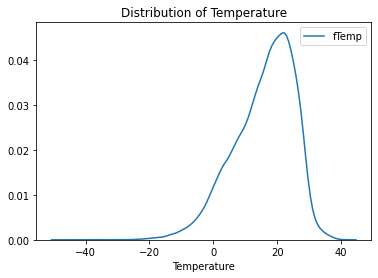

In [465]:
sns.kdeplot(df_new['fTemp'])
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Precipitation')

Text(0.5, 0, 'Precipitation')

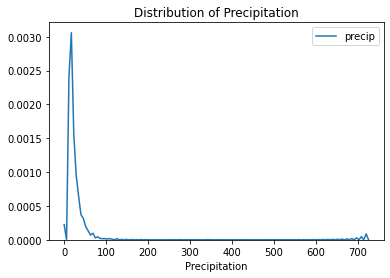

In [466]:
sns.kdeplot(df_new['precip'])
plt.title('Distribution of Precipitation')
plt.xlabel('Precipitation')

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Visibility')

Text(0.5, 0, 'Visibility')

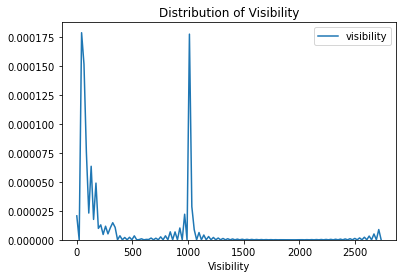

In [467]:
sns.kdeplot(df_new['visibility'])
plt.title('Distribution of Visibility')
plt.xlabel('Visibility')

In [39]:
df_new['sConditions']=df_new['sConditions'].fillna('missing_value')

In [471]:
print('Temperature skewness:')
print(df_new['fTemp'].skew())
print('\n')
print('Precipitation skewness:')
print(df_new['precip'].skew())
print('\n')
print('Visibility skewness')
print(df_new['visibility'].skew())

Temperature skewness:
-0.7170969291763591


Precipitation skewness:
19.78311680205633


Visibility skewness
14.695956664526234


In [40]:
from scipy.stats.mstats import winsorize
#winsorization has a default setting to propagate NaN: allows nan values and may overwrite or propagate them
#Replacing the outliers on the upper side with 95% percentile value and outlier on the lower side with 5% percentile

df_new['fTemp_winsorized'] = winsorize(df_new['fTemp'],limits =[0.05, 0.05])
df_new['fTemp'].max(),df_new['fTemp_winsorized'].max(),df_new['fTemp'].min(),df_new['fTemp_winsorized'].min()

(41.4, 28.8, -47.4, -1.4)

In [41]:
df_new['precip_winsorized'] = winsorize(df_new['precip'],limits =[0.05, 0.05]) 
df_new['precip'].max(),df_new['precip_winsorized'].max(),df_new['precip'].min(),df_new['precip_winsorized'].min()

(726.21, 14.99, 0.0, 0.0)

In [126]:
# df_new['precip_winsorized']=np.sqrt(df_new['precip_winsorized']) #Square root 

In [42]:
df_new['visibility_winsorized'] = winsorize(df_new['visibility'],limits =[0.05, 0.05]) 
df_new['visibility'].max(),df_new['visibility_winsorized'].max(),df_new['visibility'].min(),df_new['visibility_winsorized'].min()

(2733.3, 24.0, 0.0, 9.7)

In [486]:
print('Temperature skewness:')
print(df_new['fTemp_winsorized'].skew())
print('\n')
print('Precipitation skewness:')
print(df_new['precip_winsorized'].skew())
print('\n')
print('Visibility skewness')
print(df_new['visibility_winsorized'].skew())

Temperature skewness:
-0.454317219927424


Precipitation skewness:
1.8964021611252047


Visibility skewness
0.9280578592246891


In [43]:
#dropping columns since I winsorized them already
df_new.drop(['fTemp','precip','visibility'],axis=1,inplace=True)

In [488]:
#I don't worry about ufo_year because I will drop it for modelling. Surrogates often have high kurtosis as well
df_new.kurtosis(numeric_only=True)

Text_ID                           -1.197240
AIRPORT_DISTANCE                   7.781441
AIRPORT_AZIMUTH                   -1.254447
WATER_BODY_DISTANCE                0.917607
WATER_BODY_AZIMUTH                -0.798881
bIsNearWater                      -0.266252
delta_posted_event                20.395714
ufo_year                          11.480870
ufo_month                         -0.949875
ufo_day                           -1.181180
ufo_hour                          -0.633848
ufo_minute                        -1.152283
ufo_weekday_number                -1.220040
ufo_month_sin                     -1.357284
ufo_month_cos                     -1.492048
ufo_day_sin                       -1.412759
ufo_day_cos                       -1.535818
ufo_hour_sin                       0.095815
ufo_hour_cos                      -0.317342
ufo_minute_sin                    -0.116449
ufo_minute_cos                    -1.503855
ufo_weekday_sin                   -1.470434
ufo_weekday_cos                 

In [489]:
df_new['delta_posted_event'].skew()

4.471310696391027

<AxesSubplot:>

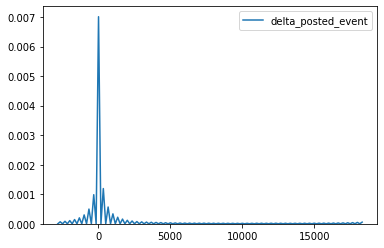

In [490]:
sns.kdeplot(df_new['delta_posted_event'])

In [44]:
#there are too many outliers to drop so I decided to winsorize 9%

df_new['delta_posted_event_winsorized'] = winsorize(df_new['delta_posted_event'],limits =[0.09, 0.09]) 
df_new['delta_posted_event'].max(),df_new['delta_posted_event_winsorized'].max(),df_new['delta_posted_event'].min(),df_new['delta_posted_event_winsorized'].min()

(18315, 926, -2783, 2)

In [492]:
df_new['delta_posted_event_winsorized'].skew()

2.4452260736360536

In [45]:
df_new.drop('delta_posted_event',axis=1,inplace=True)

In [494]:
df_new.kurtosis(numeric_only=True)

Text_ID                           -1.197240
AIRPORT_DISTANCE                   7.781441
AIRPORT_AZIMUTH                   -1.254447
WATER_BODY_DISTANCE                0.917607
WATER_BODY_AZIMUTH                -0.798881
bIsNearWater                      -0.266252
ufo_year                          11.480870
ufo_month                         -0.949875
ufo_day                           -1.181180
ufo_hour                          -0.633848
ufo_minute                        -1.152283
ufo_weekday_number                -1.220040
ufo_month_sin                     -1.357284
ufo_month_cos                     -1.492048
ufo_day_sin                       -1.412759
ufo_day_cos                       -1.535818
ufo_hour_sin                       0.095815
ufo_hour_cos                      -0.317342
ufo_minute_sin                    -0.116449
ufo_minute_cos                    -1.503855
ufo_weekday_sin                   -1.470434
ufo_weekday_cos                   -1.489297
shape_surrogate                 

In [51]:
missing_prop=df_new.isna().sum()/len(df_new)
missing_prop[missing_prop>0].sort_values(ascending=False)

AIRPORT_DISTANCE       0.002777
AIRPORT_AZIMUTH        0.002777
WATER_BODY_DISTANCE    0.002777
WATER_BODY_AZIMUTH     0.002777
dtype: float64

In [46]:
#combining rate categories:

def CombineRareCategories(data,pct):
    for col in data[['state','shape','WATER_BODY_NAME','bIsRuralArea','sConditions']].columns:
        for index,row in pd.DataFrame(data[col].value_counts()/len(data)*100).iterrows():
                if (row[0]<pct):
                    data[col].replace(index,'Other_'+col,inplace=True)
                else:
                    None
CombineRareCategories(df_new,4.0)

In [497]:
print(df_new['state'].value_counts()/len(df_new)*100)

Other_state          67.945379
CA                   11.004792
Outside US/Canada     6.447760
FL                    5.975798
WA                    4.464941
TX                    4.161331
Name: state, dtype: float64


In [498]:
print(df_new['shape'].value_counts()/len(df_new)*100)

light          22.737672
disk           20.662762
ball           15.725859
other          15.213606
geometric      13.699872
changing        5.582975
cylinder        4.118163
Other_shape     2.259090
Name: shape, dtype: float64


In [499]:
print(df_new['WATER_BODY_NAME'].value_counts()/len(df_new)*100)

Unknown                  22.783717
Atlantic Ocean           18.629581
Pacific Ocean            18.264098
Other_WATER_BODY_NAME    16.983467
Gulf of Mexico            6.618991
Lake Michigan             6.516828
Lake Erie                 5.685137
Chesapeake Bay            4.518181
Name: WATER_BODY_NAME, dtype: float64


In [500]:
print(df_new['sConditions'].value_counts()/len(df_new)*100)

Clear                39.125430
Mist                 23.848511
Fog                  11.761659
Rain                 11.486827
Drizzle               5.944141
Haze                  4.030390
Other_sConditions     3.803042
Name: sConditions, dtype: float64


In [47]:
df_full=df_new.copy()

In [48]:
wn=nltk.WordNetLemmatizer()
stop_words=set(stopwords.words('english')+stopwords.words('spanish')+['u','im','dont','cuz','lol','ur','ure','doing','nuforc note','ufo','see','nuforc'])
from textblob import TextBlob


def clean_text(text):
    text=str(text)
    
    if text.strip()=='':
        return ' '
    text="".join([char.lower() for char in text if char not in string.punctuation])
    text= re.sub(r'\d+', '', text)
    text=re.sub(r'http\S+|www\S+', '', text).strip()
    tokens=nltk.word_tokenize(text.strip())
    text=[t for t in tokens if t not in stop_words]
    text=[unidecode.unidecode(w) for w in text]
    text=" ".join([wn.lemmatize(word,'v')for word in text])
    text=" ".join([word for word in text.split()]) 
    return text

df_full["text_clean"]=df_full["text"].apply(clean_text)

In [49]:
from collections import Counter
cnt = Counter()
for text in df_full["text_clean"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('light', 180101),
 ('object', 97131),
 ('sky', 85931),
 ('move', 76051),
 ('look', 72573),
 ('saw', 61949),
 ('like', 58567),
 ('go', 56378),
 ('one', 48665),
 ('bright', 46924)]

In [50]:
# Removing the frequent words
freq = set([w for (w, wc) in cnt.most_common(10)])

# function to remove the frequent words
def freqwords(text):
    return " ".join([word for word in str(text).split() if word not in freq])

# Passing the function freqwords
df_full["text_common"] = df_full["text_clean"].apply(freqwords)
df_full["text_common"].head()

0    wife drive southeast fairly populate main side...
1    think may catch nbc nightly news air march st ...
2    drive towards intersection fallowfield eagleso...
3    peoria arizona cigar shape craft float neighbo...
4    flash green blue red white revolve around hove...
Name: text_common, dtype: object

### Features from Text

In [51]:
import textstat

df_full["text_len"]=df_full["text"].apply(lambda x:len(x)-x.count(" "))
#readability scores
df_full['flesch_reading_ease']=df_full['text'].apply(textstat.flesch_reading_ease)
df_full['automated_readability']=df_full['text'].apply(textstat.automated_readability_index)
#counts the number of words present in the text
df_full['lexicon_count']=df_full['text'].apply(textstat.lexicon_count,removepunct=True)
df_full['speed_fast']=[word.count('fast') for word in df_full['text']]
df_full['speed_slow']=[word.count('slow') for word in df_full['text']]
df_full['speed_high']=[word.count('high speed') for word in df_full['text']]
df_full['text_exclamation']=[word.count('!') for word in df_full['text']]

In [52]:
q1 = """SELECT DN.*,
        CASE WHEN text like '%afraid%' or text like '%scared%' or text like '%terrified%' then 1 else 0 end as text_fear,
        CASE WHEN text like '%boeing%' or text like '%airlines%' then 1 else 0 end as text_flight
        
from df_full DN
"""
df_full= ps.sqldf(q1, locals())

In [53]:
def count_capitalized(text):
    count=sum([1 for char in text if char.isupper()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df_full["text_capitalized"]=df_full["text"].apply(lambda x:count_capitalized(x))

In [54]:
def count_punctuation(text):
    count=sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100 

df_full["text_punctuation"]=df_full["text"].apply(lambda x:count_punctuation(x)) 

In [55]:
def count_digit(text):
    count=sum([1 for char in text if char.isdigit()])
    return count

df_full["text_digit"]=df_full["text"].apply(lambda x:count_digit(x))  

In [56]:
df_full['title_word_count'] = df_full['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df_full['stopword_count'] = df_full['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [57]:
df_full.drop(['country_python','text','ufo_weekday_number','ufo_weekday_name','ufo_month','ufo_minute', 'ufo_hour',
              'date_time', 'ufo_day','ufo_year','city_clean','posted','text_clean'],axis=1,inplace=True) 

In [520]:
df_full['state'].value_counts()/len(df_full)

Other_state          0.679485
CA                   0.110063
Outside US/Canada    0.064469
FL                   0.059747
WA                   0.044601
TX                   0.041635
Name: state, dtype: float64

In [521]:
df_full['bIsRuralArea'].value_counts()/len(df_full)

urban      0.597740
rural      0.340441
Unknown    0.061820
Name: bIsRuralArea, dtype: float64

In [184]:
df_full_copy=df_full.copy()

In [185]:
df_full_copy.drop('Text_ID',axis=1,inplace=True)

In [186]:
dictionary={'minutes':0,'seconds':1,'Unknown':2,'hours':3,'nights':4}

df_full_copy['Duration Category']=df_full_copy['Duration Category'].map(dictionary)

In [187]:
X = df_full_copy.drop("Duration Category",axis=1)
y = df_full_copy[['Duration Category']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

In [62]:
missing_prop=X_train.isna().sum()/len(X_train)
missing_prop[missing_prop>0].sort_values(ascending=False)

AIRPORT_DISTANCE       0.002734
AIRPORT_AZIMUTH        0.002734
WATER_BODY_DISTANCE    0.002734
WATER_BODY_AZIMUTH     0.002734
dtype: float64

In [188]:
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
imputer.fit(X_train.select_dtypes(include=['int64','float64']))
X_train[X_train.select_dtypes(include=['int64','float64']).columns] = imputer.transform(X_train.select_dtypes(include=['int64','float64']))
X_test[X_test.select_dtypes(include=['int64','float64']).columns] = imputer.transform(X_test.select_dtypes(include=['int64','float64']))


SimpleImputer(strategy='most_frequent')

In [64]:
missing_prop=X_train.isna().sum()/len(X_train)
missing_prop[missing_prop>0].sort_values(ascending=False)

Series([], dtype: float64)

In [189]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_columns=X_train[['state','shape','sConditions','WATER_BODY_NAME','bIsRuralArea']].columns

X_train_encoded = encoder.fit_transform(X_train[encoder_columns])
X_train_ohe=pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(X_train[encoder_columns].columns))

In [190]:
X_test_encoded=encoder.transform(X_test[encoder_columns])
X_test_ohe=pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names(X_train[encoder_columns].columns))

In [191]:
X_train_new=X_train.copy()
X_test_new=X_test.copy()

In [192]:
X_train_new.drop(encoder_columns,axis=1,inplace=True)
X_test_new.drop(encoder_columns,axis=1,inplace=True)

In [193]:
#reseting index to be able to join dataframes properly
X_train_new.reset_index(drop=True, inplace=True)
X_train_ohe.reset_index(drop=True, inplace=True)

X_test_new.reset_index(drop=True, inplace=True)
X_test_ohe.reset_index(drop=True, inplace=True)

In [194]:
X_train_new = pd.concat([X_train_new,X_train_ohe],axis=1)
X_test_new=pd.concat([X_test_new,X_test_ohe],axis=1)

In [1271]:
X_train_new.shape

(55597, 79)

In [400]:
X_test_new.shape

(13900, 79)

In [492]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
    X_test_new.head()

,AIRPORT_DISTANCE,AIRPORT_AZIMUTH,WATER_BODY_DISTANCE,WATER_BODY_AZIMUTH,bIsNearWater,season,time_of_day,ufo_month_sin,ufo_month_cos,ufo_day_sin,ufo_day_cos,ufo_hour_sin,ufo_hour_cos,ufo_minute_sin,ufo_minute_cos,ufo_weekday_sin,ufo_weekday_cos,WATER_BODY_DISTANCE_surrogate,visibility_surrogate,WATER_BODY_AZIMUTH_surrogate,shape_surrogate,AIRPORT_AZIMUTH_surrogate,fTemp_surrogate,sConditions_surrogate,precip_surrogate,AIRPORT_NAME_surrogate,AIRPORT_DISTANCE_surrogate,WATER_BODY_NAME_surrogate,URBAN_AREA_surrogate,sentiment,fTemp_winsorized,precip_winsorized,visibility_winsorized,delta_posted_event_winsorized,text_common,text_len,flesch_reading_ease,automated_readability,lexicon_count,speed_fast,speed_slow,speed_high,text_exclamation,fear,text_capitalized,text_punctuation,text_digit,state_CA,state_FL,state_Other_state,state_Outside US/Canada,state_TX,state_WA,shape_Other_shape,shape_ball,shape_changing,shape_cylinder,shape_disk,shape_geometric,shape_light,shape_other,sConditions_Clear,sConditions_Drizzle,sConditions_Fog,sConditions_Haze,sConditions_Mist,sConditions_Other_sConditions,sConditions_Rain,WATER_BODY_NAME_Atlantic Ocean,WATER_BODY_NAME_Chesapeake Bay,WATER_BODY_NAME_Gulf of Mexico,WATER_BODY_NAME_Lake Erie,WATER_BODY_NAME_Lake Michigan,WATER_BODY_NAME_Other_WATER_BODY_NAME,WATER_BODY_NAME_Pacific Ocean,WATER_BODY_NAME_Unknown,bIsRuralArea_Unknown,bIsRuralArea_rural,bIsRuralArea_urban,cluster
0,1.6,1.0,0.3,1.1,0.5,0.0,1.0,-1.1,0.8,-0.0,1.3,-0.9,-0.6,-1.7,0.2,1.4,-0.2,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.5,1.2,0.8,-1.1,-0.5,-0.1,-0.4,five distinct glow five distinct orange glow o...,-0.8,0.4,-0.6,-0.9,-0.4,-0.5,-0.1,-0.2,-0.2,-0.2,2.7,-0.7,-0.4,-0.2,0.7,-0.3,-0.2,-0.2,-0.2,2.3,-0.2,-0.2,-0.5,-0.4,-0.5,-0.4,-0.8,-0.3,2.7,-0.2,-0.6,-0.2,-0.4,2.1,-0.2,-0.3,-0.2,-0.3,-0.5,-0.5,-0.5,-0.3,1.4,-1.2,4
1,3.5,-0.1,0.0,-1.4,0.5,2.0,1.0,-0.5,-1.1,0.3,1.3,-0.7,-1.4,-0.2,0.9,0.0,1.5,-0.1,9.8,-0.1,-0.2,-0.1,9.8,9.8,9.8,-0.1,-0.1,-0.5,1.2,-1.4,1.5,2.9,3.0,3.0,ft orange saucer cup top sound lake shoot air ...,-0.1,0.4,-0.4,-0.0,-0.4,0.7,-0.1,-0.2,-0.2,-0.1,0.2,0.0,-0.4,-0.2,0.7,-0.3,-0.2,-0.2,-0.2,-0.4,-0.2,-0.2,-0.5,-0.4,-0.5,2.4,-0.8,-0.3,-0.4,-0.2,-0.6,5.0,-0.4,-0.5,-0.2,-0.3,-0.2,-0.3,2.2,-0.5,-0.5,-0.3,1.4,-1.2,4
2,-0.2,-1.0,-0.4,-1.2,0.5,2.0,1.0,-0.5,-1.1,1.1,0.9,-0.9,-0.1,-1.1,0.7,-0.6,-1.1,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.5,-0.8,0.8,0.5,-0.5,-0.9,-0.3,red fireworks red semicircledreamcatcher shape...,-0.7,0.5,-0.6,-0.8,-0.4,0.7,-0.1,-0.2,-0.2,-0.3,-0.1,-0.2,2.8,-0.2,-1.5,-0.3,-0.2,-0.2,-0.2,-0.4,-0.2,-0.2,-0.5,-0.4,-0.5,2.4,-0.8,-0.3,-0.4,-0.2,1.8,-0.2,-0.4,-0.5,-0.2,-0.3,-0.2,-0.3,-0.5,2.1,-0.5,-0.3,-0.7,0.8,4
3,-0.5,1.3,1.3,1.3,0.5,0.0,0.0,-1.3,0.1,1.2,-0.7,1.2,-2.2,-1.7,0.2,-0.6,-1.1,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.5,1.2,0.8,0.6,-0.5,0.1,-0.3,red white blue pa fall smoke father back porch...,0.3,0.7,-0.7,0.4,-0.4,-0.5,-0.1,-0.2,-0.2,0.0,0.2,-0.7,-0.4,-0.2,0.7,-0.3,-0.2,-0.2,-0.2,-0.4,-0.2,-0.2,2.0,-0.4,-0.5,-0.4,-0.8,-0.3,-0.4,4.9,-0.6,-0.2,-0.4,2.1,-0.2,-0.3,-0.2,-0.3,-0.5,-0.5,-0.5,-0.3,1.4,-1.2,4
4,0.3,0.6,-0.0,0.7,0.5,3.0,1.0,1.4,0.8,0.6,-1.3,-0.9,-0.6,-0.7,-1.4,1.1,1.0,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.5,-0.8,0.8,-1.9,-0.5,-1.3,-0.4,red ball see plainfield glow dim fly come hous...,-0.6,-0.3,0.3,-0.5,-0.4,0.7,-0.1,-0.2,-0.2,-0.3,-1.9,-0.7,-0.4,-0.2,0.7,-0.3,-0.2,-0.2,-0.2,-0.4,-0.2,-0.2,2.0,-0.4,-0.5,-0.4,-0.8,-0.3,-0.4,-0.2,1.8,-0.2,-0.4,-0.5,-0.2,-0.3,-0.2,3.8,-0.5,-0.5,-0.5,-0.3,-0.7,0.8,4


In [195]:
numerical_features = X_train_new.select_dtypes(include=['int64', 'float64']).columns

In [196]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for v in numerical_features:
    scale=scaler.fit(X_train_new[[v]])
    X_train_new[v]=scale.transform(X_train_new[[v]])
    X_test_new[v]=scale.transform(X_test_new[[v]])   

In [197]:
#Ordinal encoding season
oe=OrdinalEncoder()
oe.fit(X_train_new[['season']])
X_train_new['season']=oe.transform(X_train_new[['season']])
X_test_new['season']=oe.transform(X_test_new[['season']])

OrdinalEncoder()

In [74]:
#Ordinal encoding time of day
oe = OrdinalEncoder()
oe.fit(X_train_new[['time_of_day']])
X_train_new['time_of_day']=oe.transform(X_train_new[['time_of_day']])
X_test_new['time_of_day']=oe.transform(X_test_new[['time_of_day']])

OrdinalEncoder()

In [663]:
print(X_train_new.shape)
print(y_train.shape)

(55597, 81)
(55597, 1)


In [75]:
from imblearn.over_sampling import RandomOverSampler 

# define oversample strategy
oversample = RandomOverSampler()

# fit and apply the transform
X_resampled, y_resampled = oversample.fit_resample(X_train_new, y_train)

In [106]:
X_resampled.shape

(167095, 57)

In [1167]:
y_resampled.value_counts()

Duration Category
0                    33440
1                    33440
2                    33440
3                    33440
4                    33440
dtype: int64

In [76]:
season_feature=['season']
time_of_day=_feature=['time_of_day']
condition_feature=['sConditions']
text='text_common'

all_num_features= X_resampled.select_dtypes(include=['int64', 'float64']).columns

In [77]:
tfidf_vect = TfidfVectorizer(max_df=0.8,min_df=0.02,ngram_range=[1,2])

df_tfidf = tfidf_vect.fit(X_resampled["text_common"])

X_tfidf_train=df_tfidf.transform(X_resampled["text_common"])
X_tfidf_test=df_tfidf.transform(X_test_new["text_common"])

In [495]:
tfidf_features_test.head()

,able,absolutely,across,actually,ago,air,aircraft,airplane,airplanes,airport,...,wonder,work,would,write,yard,year,years,yellow,yet,zoom
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.111146,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.118603,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [78]:
tfidf_features_train=pd.DataFrame(X_tfidf_train.toarray(),columns=tfidf_vect.get_feature_names())
tfidf_features_test=pd.DataFrame(X_tfidf_test.toarray(),columns=tfidf_vect.get_feature_names())

In [133]:
tfidf_features_train.columns

Index(['able', 'absolutely', 'across', 'actually', 'ago', 'air', 'aircraft',
       'airplane', 'airplanes', 'airport',
       ...
       'wonder', 'work', 'would', 'write', 'yard', 'year', 'years', 'yellow',
       'yet', 'zoom'],
      dtype='object', length=620)

In [79]:
#Combining all together before proceeding with classification
X_count_features_train=pd.concat([X_resampled.reset_index(drop=True),
                            tfidf_features_train], axis=1)

X_count_features_test=pd.concat([X_test_new.reset_index(drop=True),
                            tfidf_features_test], axis=1)

In [80]:
#removing already vectorized text feature
X_count_features_train.drop('text_common',axis=1,inplace=True)
X_count_features_test.drop('text_common',axis=1,inplace=True)

In [1193]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     X_count_features_train.head()

,AIRPORT_DISTANCE,AIRPORT_AZIMUTH,WATER_BODY_DISTANCE,WATER_BODY_AZIMUTH,bIsNearWater,fTemp_surrogate,shape_surrogate,WATER_BODY_NAME_surrogate,AIRPORT_NAME_surrogate,AIRPORT_AZIMUTH_surrogate,sConditions_surrogate,visibility_surrogate,URBAN_AREA_surrogate,precip_surrogate,WATER_BODY_DISTANCE_surrogate,AIRPORT_DISTANCE_surrogate,WATER_BODY_AZIMUTH_surrogate,IsWeekend,season,time_of_day,ufo_month_sin,ufo_month_cos,ufo_day_sin,ufo_day_cos,ufo_hour_sin,ufo_hour_cos,ufo_minute_sin,ufo_minute_cos,ufo_weekday_sin,ufo_weekday_cos,sentiment,fTemp_winsorized,precip_winsorized,visibility_winsorized,delta_posted_event_winsorized,text_len,flesch_reading_ease,automated_readability,lexicon_count,speed_fast,speed_slow,speed_high,text_exclamation,fear,flight,text_capitalized,text_punctuation,text_digit,state_CA,state_FL,state_Other_state,state_Outside US/Canada,state_TX,state_WA,shape_Other_shape,shape_ball,shape_changing,shape_cylinder,shape_disk,shape_geometric,shape_light,shape_other,sConditions_Clear,sConditions_Drizzle,sConditions_Fog,sConditions_Haze,sConditions_Mist,sConditions_Other_sConditions,sConditions_Rain,WATER_BODY_NAME_Atlantic Ocean,WATER_BODY_NAME_Chesapeake Bay,WATER_BODY_NAME_Gulf of Mexico,WATER_BODY_NAME_Lake Erie,WATER_BODY_NAME_Lake Michigan,WATER_BODY_NAME_Other_WATER_BODY_NAME,WATER_BODY_NAME_Pacific Ocean,WATER_BODY_NAME_Unknown,bIsRuralArea_Unknown,bIsRuralArea_rural,bIsRuralArea_urban,cluster,able,across,actually,ago,air,aircraft,airplane,airplanes,airport,alien,almost,along,also,although,altitude,always,amaze,angle,anonymous,anonymous provide,another,anyone,anyone else,anything,apart,appear,approach,approx,approximate,approximate pd,approximately,area,around,around pm,ask,assume,atmosphere,attention,away,back,back forth,backyard,ball,balloon,base,beach,beam,become,bed,begin,behind,believe,best,better,big,bigger,binoculars,bite,black,blink,block,blue,body,bottom,break,brighter,brightness,brother,build,ca,call,camera,cant,capture,car,catch,cause,cell,cell phone,center,certain,change,change color,check,cigarette,circle,circular,city,clear,clear night,clearly,close,closer,cloud,color,come,come back,commercial,completely,contact,contact information,continue,corner,could,could tell,couldnt,county,couple,course,cover,craft,crazy,cross,dark,date,date incident,date sight,daughter,day,days,decide,definitely,degree,degrees,delete,describe,detail,didnt,different,dim,direction,directions,directly,disappear,disk,distance,dog,door,dot,drive,drive home,drop,due,earlier,early,earth,east,east west,eastern,edge,either,elect,elect remain,else,emit,end,enough,entire,estimate,even,event,eventually,ever,ever see,every,every night,exact,exactly,except,experience,explain,explanation,extremely,eye,face,fact,fade,faint,fairly,fall,family,far,far away,fast,faster,feel,feet,felt,field,figure,finally,find,fire,fireball,first,first think,first time,five,flash,flash red,flicker,flight,float,fly,focus,follow,force,form,formation,forth,four,friend,friends,front,ft,full,get,get closer,girlfriend,give,glow,good,grab,great,green,grind,group,guess,half,hand,happen,hard,head,hear,height,helicopter,helicopters,help,high,higher,highway,hill,hold,home,hope,horizon,hour,hours,house,hover,however,huge,husband,idea,image,immediately,incident,incident approximate,indicate,indicate date,information,information pd,inside,interest,ive,ive see,jet,july,keep,kind,know,lake,land,large,larger,last,last night,late,later,lead,least,leave,leave right,length,less,let,level,life,line,little,live,local,locate,location,long,longer,lose,lot,low,lower,make,make noise,make sound,man,many,may,maybe,mean,mention,meteor,middle,might,mile,miles,miles away,military,min,mind,minute,minutes,minutes later,moment,months,moon,morning,mother,motion,mountain,mountains,movement,much,multiple,must,naked,naked eye,name,near,need,neighbor,never,never see,new,news,next,night,nights,noise,none,normal,north,north south,northeast,northwest,note,note witness,nothing,notice,number,observe,occur,o

In [81]:
from sklearn import preprocessing

numerical_features=X_train_new[['speed_fast','speed_high','lexicon_count','text_capitalized','flesch_reading_ease','text_len',
                            'automated_readability','text_punctuation','speed_slow','text_exclamation','text_digit',
                            'sentiment','AIRPORT_DISTANCE','AIRPORT_AZIMUTH','WATER_BODY_DISTANCE','WATER_BODY_AZIMUTH']].columns

power = preprocessing.PowerTransformer()

for v in numerical_features:
    scale=power.fit(X_count_features_train[[v]])
    X_count_features_train[v]=power.transform(X_count_features_train[[v]])
    X_count_features_test[v]=power.transform(X_count_features_test[[v]])   

### Trying deep Random Forest

In [124]:
rf=RandomForestClassifier(random_state=42,max_depth=30, min_samples_leaf=20,min_samples_split=7) 

rf.fit(X_count_features_train,y_resampled)

RandomForestClassifier(max_depth=30, min_samples_leaf=20, min_samples_split=7,
                       random_state=42)

In [106]:
y_pred_rf_train=rf.predict(X_count_features_train)
y_pred_rf_test=rf.predict(X_count_features_test)

In [107]:
from sklearn.metrics import accuracy_score
train_acc=accuracy_score(y_resampled,y_pred_rf_train)
train_acc

0.9555861244019139

In [108]:
test_acc=accuracy_score(y_test,y_pred_rf_test)
test_acc

0.6541007194244605

### Doing Feature Selection by identifying best features

In [109]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 535 (0.024865)
2. feature 330 (0.021340)
3. feature 331 (0.014950)
4. feature 402 (0.012472)
5. feature 35 (0.011867)
6. feature 37 (0.011847)
7. feature 36 (0.011022)
8. feature 38 (0.010947)
9. feature 45 (0.010583)
10. feature 49 (0.010490)
11. feature 27 (0.009707)
12. feature 589 (0.009543)
13. feature 46 (0.009420)


<AxesSubplot:>

Text(0.5, 1.0, 'Feature importance plot')

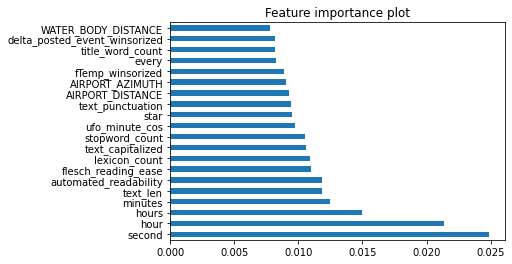

In [110]:
#Feature importance plot
#sentiment is the most important feature. flesch reading ease is also important.Most of features I created are important
feat_importances = pd.Series(rf.feature_importances_,
index=X_count_features_train.columns).sort_values(ascending=False)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Feature importance plot')

In [111]:
feat_importances = pd.Series(rf.feature_importances_,
index=X_count_features_train.columns).sort_values(ascending=False)
import_features=feat_importances.nlargest(200)

In [112]:
import_features=pd.DataFrame(import_features)
import_features

,0
second,0.024865
hour,0.021340
hours,0.014950
minutes,0.012472
text_len,0.011867
...,...
place,0.001328
horizon,0.001318
tree,0.001311
far,0.001310


In [113]:
import_features=import_features.index

In [114]:
### Fitting RF on best features identified and reducing tree depth
#Resulted in reducted overfitting but worse score

rf_feat=RandomForestClassifier(random_state=42,max_depth=10, min_samples_leaf=4,min_samples_split=2) 

rf_feat.fit(X_count_features_train[import_features],y_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, random_state=42)

In [115]:
y_pred_rf_train=rf_feat.predict(X_count_features_train[import_features])
y_pred_rf_test=rf_feat.predict(X_count_features_test[import_features])

In [116]:
train_acc=accuracy_score(y_resampled,y_pred_rf_train)
test_acc=accuracy_score(y_test,y_pred_rf_test)
train_acc,test_acc

(0.6472129186602871, 0.5158273381294964)

### Polynomial features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

import_features_100=feat_importances.nlargest(100)
import_features_100=pd.DataFrame(import_features_100)
import_features_100=import_features_100.index

polynomial_features= PolynomialFeatures(degree=2)
x_poly=polynomial_features.fit(X_count_features_train[import_features_100])

x_poly_train = x_poly.transform(X_count_features_train[import_features_100])
x_poly_test = x_poly.transform(X_count_features_test[import_features_100])

In [ ]:
model = RandomForestClassifier(random_state=42,max_depth=30, min_samples_leaf=10,min_samples_split=5)
model.fit(x_poly_train, y_resampled)

In [ ]:
y_pred_rf_train=model.predict(x_poly_train)
y_pred_rf_test=model.predict(x_poly_test)

In [ ]:
train_acc=accuracy_score(y_resampled,y_pred_rf_train)
test_acc=accuracy_score(y_test,y_pred_rf_test)
train_acc,test_acc

### Gridsearch on Ridge

In [285]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

# define models and parameters
model = RidgeClassifier(random_state=42)
alpha = [0.01,0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# define grid search
grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_count_features_train, y_resampled)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.585287 using {'alpha': 0.05}
0.585233 (0.002952) with: {'alpha': 0.01}
0.585287 (0.002958) with: {'alpha': 0.05}
0.585239 (0.002972) with: {'alpha': 0.1}
0.585191 (0.003160) with: {'alpha': 0.2}
0.585233 (0.003108) with: {'alpha': 0.3}
0.585209 (0.003043) with: {'alpha': 0.4}
0.585221 (0.003091) with: {'alpha': 0.5}
0.585150 (0.003305) with: {'alpha': 0.6}
0.584988 (0.003204) with: {'alpha': 0.7}
0.584898 (0.003119) with: {'alpha': 0.8}
0.584892 (0.003012) with: {'alpha': 0.9}


### Ensembling

In [316]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

base_models=[('gb',XGBClassifier(random_state=42,learning_rate=0.2,max_depth=20)),
            ('dt',DecisionTreeClassifier(random_state=42))]

meta_model=RandomForestClassifier()

model_stack=StackingClassifier(estimators=base_models,
                               final_estimator=meta_model,
                               passthrough=True,
                               cv=10)

In [317]:
model_stack.fit(X_count_features_train,y_resampled)

In [305]:
y_pred_rf_train=model_stack.predict(X_count_features_train)
y_pred_rf_test=model_stack.predict(X_count_features_test)

In [306]:
train_acc=accuracy_score(y_resampled,y_pred_rf_train)
test_acc=accuracy_score(y_test,y_pred_rf_test)
train_acc,test_acc

(0.9989354066985646, 0.6361870503597122)

### Feature Selection using SelectFromModel

In [1356]:
from sklearn.feature_selection import SelectFromModel

rf=SelectFromModel(RandomForestClassifier(random_state=42,max_depth=30, min_samples_leaf=1,max_features=15)) #kaggle 0.63

rf.fit(X_count_features_train,y_resampled) 

SelectFromModel(estimator=RandomForestClassifier(max_depth=30, max_features=15,
                                                 random_state=42))

In [1357]:
selected_feats=X_count_features_train.columns[(rf.get_support())]

In [1358]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     display(selected_feats)

Index(['AIRPORT_DISTANCE', 'AIRPORT_AZIMUTH', 'WATER_BODY_DISTANCE',
       'WATER_BODY_AZIMUTH', 'shape_surrogate', 'URBAN_AREA_surrogate',
       'season', 'time_of_day', 'ufo_month_sin', 'ufo_month_cos',
       ...
       'us', 'video', 'view', 'watch', 'way', 'west', 'white', 'witness',
       'witness elect', 'would'],
      dtype='object', length=205)

In [1211]:
len(selected_feats)

206

In [1212]:
X_count_features_train.shape[1]

702

In [1213]:
rf=RandomForestClassifier(random_state=42,max_depth=30, min_samples_leaf=1,max_features=15)
rf.fit(X_count_features_train[selected_feats],y_resampled) 

RandomForestClassifier(max_depth=30, max_features=15, random_state=42)

In [853]:
y_pred_rf_train=rf.predict(X_count_features_train[selected_feats])
y_pred_rf_test=rf.predict(X_count_features_test[selected_feats])

In [854]:
from sklearn.metrics import accuracy_score
train_acc=accuracy_score(y_resampled,y_pred_rf_train)
train_acc

0.9961184210526316

In [855]:
test_acc=accuracy_score(y_test,y_pred_rf_test)
test_acc

0.6689208633093525

In [1295]:
from sklearn.feature_selection import SelectFromModel

gb=SelectFromModel(XGBClassifier(random_state=42))

gb.fit(X_count_features_train,y_resampled) 

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=None, max_delta_step=None,
                                        max_depth=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, random_state=42,
                                        reg_alpha=None, reg_lambda=None,
                                        scale_pos_weight=None, subsample=None,
                                    

In [1296]:
selected_feats=X_count_features_train.columns[(gb.get_support())]

In [1298]:
gb=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=None, max_delta_step=None,
                                        max_depth=None, min_child_weight=None,
                                        monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, random_state=42,
                                        reg_alpha=None, reg_lambda=None,
                                        scale_pos_weight=None, subsample=None,
                                        tree_method=None,
                                        validate_parameters=None,
                                        verbosity=None)
gb.fit(X_count_features_train[selected_feats],y_resampled) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1299]:
X_count_features_train.shape[1]

701

In [1300]:
len(selected_feats)

262

### Trying polynimial after PCA

In [1371]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X_count_features_train[selected_feats].shape[1]-1)
svd.fit(X_count_features_train[selected_feats])

TruncatedSVD(n_components=204)

In [1372]:
svd_var_ratios = svd.explained_variance_ratio_ 

In [1373]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [1374]:
select_n_components(svd_var_ratios, 0.95)

30

In [1375]:
svd = TruncatedSVD(n_components=30)
svd.fit(X_count_features_train[selected_feats])
x_train1=svd.transform(X_count_features_train[selected_feats])
x_test1=svd.transform(X_count_features_test[selected_feats])

TruncatedSVD(n_components=30)

In [1376]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)
x_poly=polynomial_features.fit(x_train1)

x_poly_train = x_poly.transform(x_train1)
x_poly_test = x_poly.transform(x_test1)

In [1378]:
model = RandomForestClassifier(random_state=42)
model.fit(x_poly_train, y_resampled)

RandomForestClassifier(random_state=42)

In [1379]:
y_poly_pred_train = model.predict(x_poly_train)
y_poly_pred_test=model.predict(x_poly_test)

In [1380]:
from sklearn.metrics import accuracy_score
train_acc=accuracy_score(y_resampled,y_poly_pred_train)
train_acc

0.9999581339712919

In [1381]:
from sklearn.metrics import accuracy_score
test_acc=accuracy_score(y_test,y_poly_pred_test)
test_acc

0.6076978417266187

In [ ]:
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(10, 96)]
# evaluate a decision tree for each depth
for i in values:
# configure the model
    model = RandomForestClassifier(max_depth=i,random_state=42)
    # fit model on the training dataset
    model.fit(X_count_features_train, y_resampled)
    # evaluate on the train dataset
    train_yhat = model.predict(X_count_features_train)
    train_acc = accuracy_score(y_resampled, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_count_features_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

RandomForestClassifier(max_depth=10, random_state=42)

>10, train: 0.673, test: 0.515


RandomForestClassifier(max_depth=11, random_state=42)

>11, train: 0.707, test: 0.525


RandomForestClassifier(max_depth=12, random_state=42)

>12, train: 0.737, test: 0.538


RandomForestClassifier(max_depth=13, random_state=42)

>13, train: 0.766, test: 0.549


RandomForestClassifier(max_depth=14, random_state=42)

>14, train: 0.795, test: 0.561


RandomForestClassifier(max_depth=15, random_state=42)

>15, train: 0.822, test: 0.574


RandomForestClassifier(max_depth=16, random_state=42)

>16, train: 0.846, test: 0.579


RandomForestClassifier(max_depth=17, random_state=42)

>17, train: 0.871, test: 0.592


RandomForestClassifier(max_depth=18, random_state=42)

>18, train: 0.891, test: 0.601


RandomForestClassifier(max_depth=19, random_state=42)

>19, train: 0.912, test: 0.613


RandomForestClassifier(max_depth=20, random_state=42)

>20, train: 0.926, test: 0.618


RandomForestClassifier(max_depth=21, random_state=42)

>21, train: 0.940, test: 0.623


RandomForestClassifier(max_depth=22, random_state=42)

>22, train: 0.951, test: 0.636


RandomForestClassifier(max_depth=23, random_state=42)

>23, train: 0.960, test: 0.640


RandomForestClassifier(max_depth=24, random_state=42)

>24, train: 0.968, test: 0.648


RandomForestClassifier(max_depth=25, random_state=42)

>25, train: 0.975, test: 0.651


RandomForestClassifier(max_depth=26, random_state=42)

>26, train: 0.979, test: 0.653


RandomForestClassifier(max_depth=27, random_state=42)

>27, train: 0.982, test: 0.659


RandomForestClassifier(max_depth=28, random_state=42)

>28, train: 0.986, test: 0.659


RandomForestClassifier(max_depth=29, random_state=42)

>29, train: 0.990, test: 0.666


RandomForestClassifier(max_depth=30, random_state=42)

>30, train: 0.991, test: 0.670


RandomForestClassifier(max_depth=31, random_state=42)

>31, train: 0.992, test: 0.670


RandomForestClassifier(max_depth=32, random_state=42)

>32, train: 0.994, test: 0.675


RandomForestClassifier(max_depth=33, random_state=42)

>33, train: 0.996, test: 0.676


RandomForestClassifier(max_depth=34, random_state=42)

>34, train: 0.996, test: 0.675


RandomForestClassifier(max_depth=35, random_state=42)

>35, train: 0.997, test: 0.677


RandomForestClassifier(max_depth=36, random_state=42)

>36, train: 0.997, test: 0.678


RandomForestClassifier(max_depth=37, random_state=42)

>37, train: 0.998, test: 0.676


RandomForestClassifier(max_depth=38, random_state=42)

>38, train: 0.998, test: 0.679


RandomForestClassifier(max_depth=39, random_state=42)

>39, train: 0.999, test: 0.683


RandomForestClassifier(max_depth=40, random_state=42)

>40, train: 0.999, test: 0.684


RandomForestClassifier(max_depth=41, random_state=42)

>41, train: 0.999, test: 0.684


RandomForestClassifier(max_depth=42, random_state=42)

>42, train: 0.999, test: 0.681


RandomForestClassifier(max_depth=43, random_state=42)

>43, train: 0.999, test: 0.686


RandomForestClassifier(max_depth=44, random_state=42)

>44, train: 0.999, test: 0.685


RandomForestClassifier(max_depth=45, random_state=42)

>45, train: 1.000, test: 0.685


RandomForestClassifier(max_depth=46, random_state=42)

>46, train: 1.000, test: 0.681


RandomForestClassifier(max_depth=47, random_state=42)

>47, train: 1.000, test: 0.683


RandomForestClassifier(max_depth=48, random_state=42)

>48, train: 1.000, test: 0.682


RandomForestClassifier(max_depth=49, random_state=42)

>49, train: 1.000, test: 0.683


RandomForestClassifier(max_depth=50, random_state=42)

>50, train: 1.000, test: 0.685


In [ ]:
from matplotlib import pyplot
# plot of train and test scores vs tree depth
pyplot.title("Train vs Test data score at different tree depth",size=18)
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()


In [ ]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold

# Instantiate the classification model and visualizer
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

model =rf
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X_count_features_train, y_resampled)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [555]:
from sklearn.ensemble import ExtraTreesClassifier

et=ExtraTreesClassifier( min_samples_leaf=7, min_samples_split=3,
                     min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,random_state=42)

et.fit(X_count_features_train,y_resampled) 

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [556]:
y_pred_et=rf.predict(X_count_features_test)

### Checking multiple models with Pycaret

In [539]:
datatrain= pd.concat([X_count_features_train, y_resampled.reset_index(drop=True)], axis = 1) #join along the columns
datatest = pd.concat([X_count_features_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

In [547]:
from pycaret.classification import*



exp_clf102=setup(data=datatrain,target="Duration Category",session_id=42,test_data=datatest,silent=True)               

,Description,Value
0,session_id,42
1,Target,Duration Category
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4"
4,Original Data,"(167200, 697)"
5,Missing Values,False
6,Numeric Features,649
7,Categorical Features,47
8,Ordinal Features,False
9,High Cardinality Features,False


In [542]:
best_model=compare_models(sort="F1") 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9746,0.9950,0.9746,0.9792,0.9742,0.9682,0.9696,27.5330
rf,Random Forest Classifier,0.9666,0.9950,0.9666,0.9694,0.9664,0.9583,0.9591,69.3060
dt,Decision Tree Classifier,0.8981,0.9364,0.8981,0.9032,0.8910,0.8726,0.8767,7.6150
catboost,CatBoost Classifier,0.7988,0.9497,0.7988,0.7892,0.7908,0.7485,0.7502,321.3410
knn,K Neighbors Classifier,0.8041,0.9439,0.8041,0.7874,0.7862,0.7551,0.7597,318.5120
xgboost,Extreme Gradient Boosting,0.7792,0.9420,0.7792,0.7704,0.7718,0.7240,0.7255,330.9630
lightgbm,Light Gradient Boosting Machine,0.6597,0.8848,0.6597,0.6460,0.6500,0.5746,0.5759,22.3990
gbc,Gradient Boosting Classifier,0.4858,0.7696,0.4858,0.4774,0.4788,0.3572,0.3582,699.7660
qda,Quadratic Discriminant Analysis,0.3881,0.7012,0.3881,0.3913,0.3824,0.2352,0.2372,0.8010
lr,Logistic Regression,0.3438,0.6626,0.3438,0.3443,0.3429,0.1798,0.1801,2.9430


In [543]:
et=create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9447,0.9891,0.9447,0.9560,0.9437,0.9308,0.9342
1,0.9464,0.9889,0.9464,0.9570,0.9454,0.9329,0.9361
2,0.9428,0.9881,0.9428,0.9545,0.9417,0.9285,0.9320
3,0.9468,0.9889,0.9468,0.9573,0.9459,0.9335,0.9366
4,0.9720,0.9947,0.9720,0.9746,0.9719,0.9650,0.9657
5,0.9988,1.0000,0.9988,0.9988,0.9988,0.9985,0.9985
6,0.9987,1.0000,0.9987,0.9988,0.9987,0.9984,0.9984
7,0.9989,1.0000,0.9989,0.9989,0.9989,0.9986,0.9986
8,0.9986,1.0000,0.9986,0.9986,0.9986,0.9982,0.9982
9,0.9980,1.0000,0.9980,0.9980,0.9980,0.9975,0.9975


In [554]:
et.get_params

<bound method BaseEstimator.get_params of ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)>

### Test data

In [208]:
df_test = pd.read_csv("C:/Users/krist/Desktop/Python learning/datasets/ufo_test.csv") 

In [97]:
df_test.head()

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude
0,70501,Winnipeg,MB,2015-12-12T21:30:00,circle,Three bright orange circular lights in the eas...,2015-12-17T00:00:00,49.891260,-97.152850
1,70502,Tampa,FL,2015-12-12T21:30:00,light,"Large light formation South Tampa, near MacDil...",2015-12-17T00:00:00,28.006814,-82.476461
2,70503,Aberdeen,MD,2015-12-12T22:30:00,rectangle,Myself and another guy had just walked out fro...,2015-12-17T00:00:00,39.498400,-76.196600
3,70504,Hamburg,MI,2015-12-12T23:00:00,oval,Bright orange oval shaped object moving slowl...,2015-12-17T00:00:00,42.448700,-83.801600
4,70505,Wilmington,NC,2015-12-13T00:10:00,light,A light in the sky in the sky went up slowly o...,2015-12-17T00:00:00,34.238375,-77.878468


In [957]:
missing_prop=df_test.isna().sum()/len(df_test)
missing_prop[missing_prop>0].sort_values(ascending=False)

city_latitude     0.163981
city_longitude    0.163981
shape             0.048854
state             0.036995
date_time         0.010440
posted            0.010440
city              0.003404
text              0.000965
dtype: float64

In [323]:
df_test.dtypes

Text_ID             int64
city               object
state              object
date_time          object
shape              object
text               object
posted             object
city_latitude     float64
city_longitude    float64
dtype: object

In [324]:
df_test.shape

(17624, 9)

In [209]:
#convert to datetime format
df_test['date_time']=pd.to_datetime(df_test['date_time'],errors='coerce')
df_test['posted']=pd.to_datetime(df_test['posted'],'coerce')
df_test['text']=df_test['text'].astype(str)

In [210]:
#trying to get cities from city that is not in USA (it is separated with '()')
df_test['city_clean']=df_test['city'].str.split('(',1).str[0]

In [211]:
df_test['city_clean']=df_test['city_clean'].astype(str)
df_test['city_clean']=df_test['city_clean'].apply(lambda x: x.strip())

In [212]:
df_test['country']=np.where(df_test['state'].isnull(),df_test['city'].str.split('(',1).str[1].str.strip(')'),np.nan)

In [213]:
import pandasql as ps

q1 = """SELECT a.*,  
        CASE WHEN state in ('ON','QC','NL','PE','NS','NB','MB','SK','AB','BC','YT','NT','NU') THEN 'Canada' 
                 WHEN state IS NOT NULL THEN 'United States' 
                 ELSE country END as country2
from df_test a """

df_test= ps.sqldf(q1, locals())

In [214]:
df_test.drop('country',axis=1,inplace=True)

In [215]:
df_test=df_test.rename(columns={'country2':"country"})

In [216]:
country_list=[]
for x in pycountry.countries:
    country_list.append(x.name)

In [217]:
def country_search(row):
    if row in country_list:
        return row
    else:
        return 'Not found'
df_test["country_python"]=df_test["country"].apply(country_search)  

In [218]:
#need to convert one more time since SQL query changes its data type
df_test['date_time']=pd.to_datetime(df_test['date_time'],errors='coerce')
df_test['posted']=pd.to_datetime(df_test['posted'],'coerce')

In [115]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_test[df_test['city_clean']=='Kiev']

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude,city_clean,country,country_python
6032,76533,Kiev (Ukraine),None,2006-09-05 12:00:00,other,"Two ""mercury"" drops the sky above Kiev, Ukrain...",2017-01-06,NaN,NaN,Kiev,Ukraine,Ukraine
7709,78210,Kiev (Ukraine),None,2017-05-17 12:00:00,sphere,Hi We did not notice anything until later on ...,2017-06-02,NaN,NaN,Kiev,Ukraine,Ukraine
12310,82811,Kiev (Ukraine),None,2018-10-01 14:00:00,cigar,"UFO sighting in Kiev, Ukraine. ((NUFORC Note: ...",2018-10-06,NaN,NaN,Kiev,Ukraine,Ukraine


In [215]:
df_test[df_test['date_time'].isna()]

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude,city_clean,country,country_python
332,70833,Vandenberg AFB,CA,NaT,cigar,Sightings during official launches of missiles...,NaT,NaN,NaN,Vandenberg AFB,United States,United States
477,70978,Brownstown,IN,NaT,disk,UFO captured during the 1948 Centennial Parade...,NaT,38.836100,-86.009200,Brownstown,United States,United States
478,70979,Hawthorne,CA,NaT,other,"It was 1954. Background. I was 24, busy build...",NaT,33.913082,-118.344353,Hawthorne,United States,United States
742,71243,Brawley,CA,NaT,disk,Aircraft was hovering about 20 ft. sucking wat...,NaT,33.027600,-115.451100,Brawley,United States,United States
1045,71546,Piedmont,MO,NaT,None,Grey entities sighted on numerous occasions on...,NaT,37.146700,-90.672200,Piedmont,United States,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
17434,87935,Knoxville,TN,NaT,light,Two bright strobing lights were stationary and...,NaT,35.961561,-83.980115,Knoxville,United States,United States
17435,87936,Pocatello,ID,NaT,formation,Walked out onto back deck and looked up. Noti...,NaT,42.874890,-112.401162,Pocatello,United States,United States
17436,87937,Chichester (UK/England),None,NaT,light,I saw what looked like a Star constellation mo...,NaT,NaN,NaN,Chichester,UK/England,Not found
17437,87938,Pontypridd (UK/Wales),None,NaT,formation,White dots in formation just appearing out of ...,NaT,NaN,NaN,Pontypridd,UK/Wales,Not found


In [219]:
#used forward fill approach to fill in missing values in date_time column

#‘ffill’ stands for ‘forward fill’ and will propagate last valid observation forward.
df_test['date_time']=df_test['date_time'].fillna(method="ffill")

In [348]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_test[df_test['city_clean']=='Kiev']

,Text_ID,city,state,date_time,shape,text,posted,city_latitude,city_longitude,city_clean,country,country_python
6032,76533,Kiev (Ukraine),None,2006-09-05 12:00:00,other,"Two ""mercury"" drops the sky above Kiev, Ukrain...",2017-01-06,NaN,NaN,Kiev,Ukraine,Ukraine
7709,78210,Kiev (Ukraine),None,2017-05-17 12:00:00,sphere,Hi We did not notice anything until later on ...,2017-06-02,NaN,NaN,Kiev,Ukraine,Ukraine
12310,82811,Kiev (Ukraine),None,2018-10-01 14:00:00,cigar,"UFO sighting in Kiev, Ukraine. ((NUFORC Note: ...",2018-10-06,NaN,NaN,Kiev,Ukraine,Ukraine


In [220]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LAPTOP-JQCGOBOD;'
                      'Database=ufo;'
                      'Trusted_Connection=yes;'
                      'Application_intent=ReadOnly')

In [221]:
cursor=conn.cursor()

cursor.execute('SELECT * FROM ufo.dbo.ufo_weather_test')    
               
ufo_weather = cursor.fetchall()
cursor.close()

In [222]:
df_test_weather= pd.DataFrame.from_records(ufo_weather, columns=['Text_ID'
                                                         ,'date_time'
                                                         ,'posted'
                                                         ,'city'
                                                         ,'state'
                                                         ,'shape'
                                                         ,'city_latitude'
                                                         ,'city_longitude'
                                                         ,'city_clean'
                                                         ,'country'
                                                         ,'country_python'
                                                         ,'sAddress'
                                                         ,'fTemp'
                                                         ,'precip'
                                                         ,'visibility'
                                                         ,'sConditions'
                                                           ])

In [223]:
#replacing blanks, empty strings wih NaN
df_test_weather=df_test_weather.replace(r'^\s*$',np.NaN,regex=True)

In [224]:
df_test_full=df_test.merge(df_test_weather,how='left',on=['Text_ID','date_time','posted','city','state','shape','city_clean','country','country_python'])

In [225]:
df_test_full.drop(['city_latitude_x','city_longitude_x','sAddress','country','city'],axis=1,inplace=True)

In [226]:
df_test_full=df_test_full.rename(columns={'city_latitude_y':"city_latitude",'city_longitude_y':'city_longitude'})

In [330]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
     df_test_full[df_test_full['city_clean']=='Kiev']

,Text_ID,state,date_time,shape,text,posted,city_clean,country_python,city_latitude,city_longitude,fTemp,precip,visibility,sConditions
6032,76533,None,2006-09-05 12:00:00,other,"Two ""mercury"" drops the sky above Kiev, Ukrain...",2017-01-06,Kiev,Ukraine,50.5,30.5,14.2,3.0,17.0,Thunder
7709,78210,None,2017-05-17 12:00:00,sphere,Hi We did not notice anything until later on ...,2017-06-02,Kiev,Ukraine,50.5,30.5,11.9,0.0,11.3,Clear
12310,82811,None,2018-10-01 14:00:00,cigar,"UFO sighting in Kiev, Ukraine. ((NUFORC Note: ...",2018-10-06,Kiev,Ukraine,50.5,30.5,9.1,0.0,11.2,Fog


In [227]:
#fill in NA for state with indicator that it is not United States/Canada
df_test_full['state']=df_test_full['state'].fillna('Outside US/Canada')

In [137]:
df_test_full.shape

(17624, 14)

In [228]:
df_test_full.drop(['city_latitude','city_longitude'],axis=1,inplace=True)

In [229]:
#‘ffill’ stands for ‘forward fill’ and will propagate last valid observation forward.
df_test_full['posted']=df_test_full['posted'].fillna(method="ffill")

In [230]:
date=pd.to_datetime(df_test_full['date_time']).dt.date
posted=pd.to_datetime(df_test_full['posted']).dt.date

df_test_full['delta_posted_event'] = (posted - date).dt.days

In [231]:
df_geo_test = pd.read_csv("C:/Users/krist/Desktop/Python learning/datasets/ufo_geo_enriched_test.csv") 

In [232]:
q1 = """SELECT DN.*,  
          AIRPORT_DISTANCE,
          AIRPORT_AZIMUTH,
          WATER_BODY_DISTANCE,
          WATER_BODY_AZIMUTH,
          WATER_BODY_NAME,
          AIRPORT_NAME,
          URBAN_AREA,
          CASE WHEN AIRPORT_NAME IS NOT NULL THEN 1 ELSE 0 END AS bIsAirport ,
          CASE WHEN WATER_BODY_FID=-1 THEN 0 ELSE 1 END AS bIsNearWater,
          CASE WHEN cast(URBAN_AREA_ID as int)=-1 AND DN.state !='Outside US/Canada' THEN 'rural'
               WHEN (cast(URBAN_AREA_ID as int)=-1 AND DN.state='Outside US/Canada') OR (cast(URBAN_AREA_ID as int) IS NULL) THEN 'Unknown'
               ELSE 'urban' END as bIsRuralArea
         
          
from df_test_full DN
left join df_geo_test as DG ON DN.Text_ID=DG.Text_ID"""

df_test_full= ps.sqldf(q1, locals())

In [233]:
#need to convert one more time since SQL query change its data type
df_test_full['date_time']=pd.to_datetime(df_test_full['date_time'],errors='coerce')
df_test_full['posted']=pd.to_datetime(df_test_full['posted'],'coerce')

In [984]:
missing_prop=df_test_full.isna().sum()/len(df_test_full)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA             38.997957
WATER_BODY_NAME        22.957331
shape                   4.885384
visibility              1.032683
AIRPORT_NAME            0.811394
fTemp                   0.783023
precip                  0.783023
sConditions             0.783023
AIRPORT_DISTANCE        0.766001
AIRPORT_AZIMUTH         0.766001
WATER_BODY_DISTANCE     0.766001
WATER_BODY_AZIMUTH      0.766001
dtype: float64

In [234]:
columns=list(set(df_test_full.columns)) 

for col in df_test_full[columns]:
    if df_test_full[col].isna().sum() != 0: 
        df_test_full[col + '_surrogate'] = df_test_full[col].isna().astype(int)

In [994]:
df_test_full.shape

(17624, 35)

In [124]:
missing_prop=df_test_full.isna().sum()/len(df_test_full)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA             38.997957
WATER_BODY_NAME        22.957331
shape                   4.885384
visibility              1.032683
AIRPORT_NAME            0.811394
fTemp                   0.783023
precip                  0.783023
sConditions             0.783023
AIRPORT_DISTANCE        0.766001
AIRPORT_AZIMUTH         0.766001
WATER_BODY_DISTANCE     0.766001
WATER_BODY_AZIMUTH      0.766001
dtype: float64

In [235]:
df_test_full['ufo_year'] = df_test_full['date_time'].dt.year
df_test_full['ufo_month'] = df_test_full['date_time'].dt.month
df_test_full['ufo_day'] = df_test_full['date_time'].dt.day
df_test_full['ufo_hour'] = df_test_full['date_time'].dt.hour
df_test_full['ufo_minute'] = df_test_full['date_time'].dt.minute
df_test_full['ufo_weekday_number'] = df_test_full['date_time'].dt.dayofweek #Sunday 6
df_test_full['ufo_weekday_name'] = df_test_full['date_time'].dt.day_name()

In [236]:
df_test_full["IsWeekend"]=df_test_full['ufo_weekday_number'].apply(IsWeekend) 

In [237]:
df_test_full["season"]=df_test_full["ufo_month"].apply(season_search) 

In [238]:
df_test_full["time_of_day"]=df_test_full["ufo_hour"].apply(time_interval)  

In [239]:
# creating cyclical hour feature.
df_test_full['ufo_month_sin'] = np.sin(df_test_full['ufo_month'] * (2. * np.pi / 12 ))
df_test_full['ufo_month_cos'] = np.cos(df_test_full['ufo_month'] * (2. * np.pi / 12 ))

# creating cyclical minute feature.
df_test_full['ufo_day_sin'] = np.sin(df_test_full['ufo_day'] * (2. * np.pi / 30 ))
df_test_full['ufo_day_cos'] = np.cos(df_test_full['ufo_day'] * (2. * np.pi / 30 ))

# creating cyclical month days feature.
df_test_full['ufo_hour_sin'] = np.sin((df_test_full['ufo_hour'] - 1) * (2. * np.pi / 24 ))
df_test_full['ufo_hour_cos'] = np.cos((df_test_full['ufo_hour'] - 1) * (2. * np.pi / 24 ))

# creating cyclical minute days feature.
df_test_full['ufo_minute_sin'] = np.sin((df_test_full['ufo_minute'] - 1) * (2. * np.pi / 60 ))
df_test_full['ufo_minute_cos'] = np.cos((df_test_full['ufo_minute'] - 1) * (2. * np.pi / 60 ))

# creating cyclical minute days feature.
df_test_full['ufo_weekday_sin'] = np.sin((df_test_full['ufo_weekday_number'] - 1) * (2. * np.pi / 7 ))
df_test_full['ufo_weekday_cos'] = np.cos((df_test_full['ufo_weekday_number'] - 1) * (2. * np.pi / 7 ))

In [1009]:
missing_prop=df_test_full.isna().sum()/len(df_test_full)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

URBAN_AREA            38.997957
WATER_BODY_NAME       22.957331
shape                  4.885384
visibility             1.032683
AIRPORT_NAME           0.811394
fTemp                  0.783023
precip                 0.783023
sConditions            0.783023
AIRPORT_AZIMUTH        0.766001
WATER_BODY_AZIMUTH     0.766001
dtype: float64

In [240]:
df_test_full['WATER_BODY_NAME']=df_test_full['WATER_BODY_NAME'].fillna('Unknown')

In [241]:
df_test_full['shape'] = np.where((df_test_full['shape']=='circle'),'disk',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'oval'),'disk',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'round'),'disk',df_test_full['shape'])

df_test_full['shape'] = np.where((df_test_full['shape'] == 'sphere'),'ball',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'fireball'),'ball',df_test_full['shape'])

df_test_full['shape'] = np.where((df_test_full['shape'] == 'cigar'),'cylinder',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'cone'),'cylinder',df_test_full['shape'])

df_test_full['shape'] = np.where((df_test_full['shape'] == 'rectangle'),'geometric',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'chevron'),'geometric',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'triangle'),'geometric',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'diamond'),'geometric',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'cross'),'geometric',df_test_full['shape'])

df_test_full['shape'] = np.where((df_test_full['shape'] == 'formation'),'changing',df_test_full['shape'])

df_test_full['shape'] = np.where((df_test_full['shape'] == 'unknown'),'other',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'egg'),'other',df_test_full['shape'])
df_test_full['shape'] = np.where((df_test_full['shape'] == 'teardrop'),'other',df_test_full['shape'])

df_test_full['shape'] = np.where((df_test_full['shape'] == 'flash'),'light',df_test_full['shape'])

df_test_full['shape']=df_test_full['shape'].fillna('missing_value')

In [413]:
df_test_full['shape'].value_counts()

light            3995
disk             3772
other            2627
geometric        2425
ball             2130
changing         1049
missing_value     861
cylinder          765
Name: shape, dtype: int64

In [242]:
df_test_full['sentiment_compound']=df_test_full['text'].apply(lambda r:sid.polarity_scores(r)["compound"])
df_test_full['sentiment']=df_test_full['sentiment_compound'].apply(score_classifier)

# dropping value of sentiment_compound,keeping sentiment only
df_test_full.drop(["sentiment_compound"],axis=1,inplace=True)

In [243]:
df_test_full.drop(['AIRPORT_NAME','URBAN_AREA','bIsAirport'],axis=1,inplace=True)

In [1018]:
missing_prop=df_test_full.isna().sum()/len(df_test_full)*100
missing_prop[missing_prop>0].sort_values(ascending=False)

shape                 4.885384
visibility            1.032683
fTemp                 0.783023
precip                0.783023
sConditions           0.783023
AIRPORT_AZIMUTH       0.766001
WATER_BODY_AZIMUTH    0.766001
dtype: float64

In [244]:
df_test_full['sConditions']=df_test_full['sConditions'].fillna('missing_value')

In [426]:
df_test_full['fTemp'].skew()

-0.6478380357973227

In [429]:
df_test_full.kurtosis()

Text_ID                   -1.200000
fTemp                      0.070534
precip                   168.021515
visibility                84.737073
delta_posted_event        29.996830
ufo_year                  28.181546
ufo_month                 -0.894103
ufo_day                   -1.165534
ufo_hour                  -0.947543
ufo_minute                -1.202819
ufo_weekday_number        -1.266160
ufo_month_sin             -1.206469
ufo_month_cos             -1.488314
ufo_day_sin               -1.454229
ufo_day_cos               -1.519836
ufo_hour_sin              -0.489536
ufo_hour_cos              -0.580295
ufo_minute_sin            -0.355237
ufo_minute_cos            -1.545294
ufo_weekday_sin           -1.481407
ufo_weekday_cos           -1.500237
visibility_surrogate      91.872002
shape_surrogate           15.525330
precip_surrogate         122.753200
sConditions_surrogate    122.753200
fTemp_surrogate          122.753200
sentiment                 -1.683123
dtype: float64

In [245]:
df_test_full['fTemp_winsorized'] = winsorize(df_test_full['fTemp'],limits =[0.05, 0.05])
df_test_full['fTemp'].max(),df_test_full['fTemp_winsorized'].max(),df_test_full['fTemp'].min(),df_test_full['fTemp_winsorized'].min()

(39.4, 28.6, -31.3, -1.5)

In [246]:
df_test_full['precip_winsorized'] = winsorize(df_test_full['precip'],limits =[0.05, 0.05]) 
df_test_full['precip'].max(),df_test_full['precip_winsorized'].max(),df_test_full['precip'].min(),df_test_full['precip_winsorized'].min()

(245.9, 14.13, 0.0, 0.0)

In [247]:
df_test_full['visibility_winsorized'] = winsorize(df_test_full['visibility'],limits =[0.05, 0.05]) 
df_test_full['visibility'].max(),df_test_full['visibility_winsorized'].max(),df_test_full['visibility'].min(),df_test_full['visibility_winsorized'].min()

(1041.5, 24.6, 0.1, 10.8)

In [248]:
#dropping columns since I winsorized them already
df_test_full.drop(['fTemp','precip','visibility'],axis=1,inplace=True)

In [440]:
df_test_full.kurtosis(numeric_only=True)

Text_ID                   -1.200000
delta_posted_event        29.996830
ufo_year                  28.181546
ufo_month                 -0.894103
ufo_day                   -1.165534
ufo_hour                  -0.947543
ufo_minute                -1.202819
ufo_weekday_number        -1.266160
ufo_month_sin             -1.206469
ufo_month_cos             -1.488314
ufo_day_sin               -1.454229
ufo_day_cos               -1.519836
ufo_hour_sin              -0.489536
ufo_hour_cos              -0.580295
ufo_minute_sin            -0.355237
ufo_minute_cos            -1.545294
ufo_weekday_sin           -1.481407
ufo_weekday_cos           -1.500237
visibility_surrogate      91.872002
shape_surrogate           15.525330
precip_surrogate         122.753200
sConditions_surrogate    122.753200
fTemp_surrogate          122.753200
sentiment                 -1.683123
fTemp_winsorized          -0.907428
precip_winsorized          2.292201
visibility_winsorized      5.075181
dtype: float64

In [249]:
df_test_full['delta_posted_event_winsorized'] = winsorize(df_test_full['delta_posted_event'],limits =[0.09, 0.09]) 
df_test_full['delta_posted_event'].max(),df_test_full['delta_posted_event_winsorized'].max(),df_test_full['delta_posted_event'].min(),df_test_full['delta_posted_event_winsorized'].min()

(18463, 282, -28, 2)

In [250]:
df_test_full.drop('delta_posted_event',axis=1,inplace=True)

In [159]:
missing_prop=df_test_full.isna().sum()/len(df_test_full)
missing_prop[missing_prop>0].sort_values(ascending=False)

AIRPORT_DISTANCE       0.00766
AIRPORT_AZIMUTH        0.00766
WATER_BODY_DISTANCE    0.00766
WATER_BODY_AZIMUTH     0.00766
dtype: float64

In [251]:
#combining rate categories:

def CombineRareCategories(data,pct):
    for col in data[['state','shape','WATER_BODY_NAME','bIsRuralArea','sConditions']].columns:
        for index,row in pd.DataFrame(data[col].value_counts()/len(data)*100).iterrows():
                if (row[0]<pct):
                    data[col].replace(index,'Other_'+col,inplace=True)
                else:
                    None
CombineRareCategories(df_test_full,4.0)

In [252]:
df_test_full1=df_test_full.copy()

In [253]:
df_test_full1["text_clean"]=df_test_full1["text"].apply(lambda x:clean_text(x))

In [254]:
# Passing the function freqwords
df_test_full1["text_common"] = df_test_full1["text_clean"].apply(freqwords)

In [255]:
df_test_full1["text_len"]=df_test_full1["text"].apply(lambda x:len(x)-x.count(" "))
#readability scores
df_test_full1['flesch_reading_ease']=df_test_full1['text'].apply(textstat.flesch_reading_ease)
df_test_full1['automated_readability']=df_test_full1['text'].apply(textstat.automated_readability_index)
#counts the number of words present in the text
df_test_full1['lexicon_count']=df_test_full1['text'].apply(textstat.lexicon_count,removepunct=True)
df_test_full1['speed_fast']=[word.count('fast') for word in df_test_full1['text']]
# df_full['fear']=[word.count('afraid''scared') for word in df_full['text']]
df_test_full1['speed_slow']=[word.count('slow') for word in df_test_full1['text']]
df_test_full1['speed_high']=[word.count('high speed') for word in df_test_full1['text']]
df_test_full1['text_exclamation']=[word.count('!') for word in df_test_full1['text']]

In [256]:
q1 = """SELECT DN.*,
        CASE WHEN text like '%afraid%' or text like '%scared%' or text like '%terrified%' then 1 else 0 end as text_fear,
        CASE WHEN text like '%boeing%' or text like '%airlines%' then 1 else 0 end as text_flight
        
from df_test_full1 DN
"""
df_test_full1= ps.sqldf(q1, locals())

In [257]:
df_test_full1["text_capitalized"]=df_test_full1["text"].apply(lambda x:count_capitalized(x))

In [258]:
df_test_full1["text_punctuation"]=df_test_full1["text"].apply(lambda x:count_punctuation(x)) 

In [259]:
df_test_full1["text_digit"]=df_test_full1["text"].apply(lambda x:count_digit(x)) 

In [260]:
df_test_full1['title_word_count'] = df_test_full1['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df_test_full1['stopword_count'] = df_test_full1['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [207]:
df_test_full1.columns

Index(['Text_ID', 'state', 'date_time', 'shape', 'text', 'posted',
       'city_clean', 'country_python', 'sConditions', 'AIRPORT_DISTANCE',
       'AIRPORT_AZIMUTH', 'WATER_BODY_DISTANCE', 'WATER_BODY_AZIMUTH',
       'WATER_BODY_NAME', 'bIsNearWater', 'bIsRuralArea',
       'visibility_surrogate', 'AIRPORT_AZIMUTH_surrogate',
       'AIRPORT_DISTANCE_surrogate', 'WATER_BODY_DISTANCE_surrogate',
       'fTemp_surrogate', 'precip_surrogate', 'shape_surrogate',
       'AIRPORT_NAME_surrogate', 'sConditions_surrogate',
       'WATER_BODY_NAME_surrogate', 'URBAN_AREA_surrogate',
       'WATER_BODY_AZIMUTH_surrogate', 'ufo_year', 'ufo_month', 'ufo_day',
       'ufo_hour', 'ufo_minute', 'ufo_weekday_number', 'ufo_weekday_name',
       'IsWeekend', 'ufo_month_sin', 'ufo_month_cos', 'ufo_day_sin',
       'ufo_day_cos', 'ufo_hour_sin', 'ufo_hour_cos', 'ufo_minute_sin',
       'ufo_minute_cos', 'ufo_weekday_sin', 'ufo_weekday_cos', 'sentiment',
       'fTemp_winsorized', 'precip_winsorized', 'v

In [261]:
df_test_full1.drop(['country_python','text','ufo_weekday_number','ufo_weekday_name','ufo_month','ufo_minute', 'ufo_hour',
              'date_time', 'ufo_day','ufo_year','city_clean','posted','text_clean'],axis=1,inplace=True)

In [262]:
df_test_full1.drop('Text_ID',axis=1,inplace=True)

In [264]:
# fixing numericals 
df_test_full1[df_test_full1.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df_test_full1.select_dtypes(include=['int64','float64']))

In [265]:
df_test_full_encoded=encoder.transform(df_test_full1[encoder_columns])

In [266]:
df_test_full_ohe=pd.DataFrame(df_test_full_encoded, columns=encoder.get_feature_names(X_train[encoder_columns].columns))

In [267]:
df_test_full1.drop(encoder_columns,axis=1,inplace=True)

In [268]:
df_test_full1.reset_index(drop=True, inplace=True)
df_test_full_ohe.reset_index(drop=True, inplace=True)

In [269]:
df_test_full1=pd.concat([df_test_full1,df_test_full_ohe],axis=1)

In [180]:
df_test_full1.shape

(17624, 81)

In [409]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', lambda x: '%.1f' % x):
    df_test_full1.head()

,AIRPORT_DISTANCE,AIRPORT_AZIMUTH,WATER_BODY_DISTANCE,WATER_BODY_AZIMUTH,bIsNearWater,season,time_of_day,ufo_month_sin,ufo_month_cos,ufo_day_sin,ufo_day_cos,ufo_hour_sin,ufo_hour_cos,ufo_minute_sin,ufo_minute_cos,ufo_weekday_sin,ufo_weekday_cos,WATER_BODY_DISTANCE_surrogate,visibility_surrogate,WATER_BODY_AZIMUTH_surrogate,shape_surrogate,AIRPORT_AZIMUTH_surrogate,fTemp_surrogate,sConditions_surrogate,precip_surrogate,AIRPORT_NAME_surrogate,AIRPORT_DISTANCE_surrogate,WATER_BODY_NAME_surrogate,URBAN_AREA_surrogate,sentiment,fTemp_winsorized,precip_winsorized,visibility_winsorized,delta_posted_event_winsorized,text_common,text_len,flesch_reading_ease,automated_readability,lexicon_count,speed_fast,speed_slow,speed_high,text_exclamation,fear,text_capitalized,text_punctuation,text_digit,state_CA,state_FL,state_Other_state,state_Outside US/Canada,state_TX,state_WA,shape_Other_shape,shape_ball,shape_changing,shape_cylinder,shape_disk,shape_geometric,shape_light,shape_other,sConditions_Clear,sConditions_Drizzle,sConditions_Fog,sConditions_Haze,sConditions_Mist,sConditions_Other_sConditions,sConditions_Rain,WATER_BODY_NAME_Atlantic Ocean,WATER_BODY_NAME_Chesapeake Bay,WATER_BODY_NAME_Gulf of Mexico,WATER_BODY_NAME_Lake Erie,WATER_BODY_NAME_Lake Michigan,WATER_BODY_NAME_Other_WATER_BODY_NAME,WATER_BODY_NAME_Pacific Ocean,WATER_BODY_NAME_Unknown,bIsRuralArea_Unknown,bIsRuralArea_rural,bIsRuralArea_urban
0,0.1,167.9,0.6,67.7,1.0,Winter,Evening,-0.0,1.0,0.6,-0.8,-0.9,0.5,0.1,-1.0,-0.4,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.5,1.5,24.6,5.0,three orange circular eastern degrees largest ...,602.0,-46.6,66.4,133.0,0.0,0.0,0.0,0.0,0.0,1.7,2.7,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.1,-151.1,0.1,-79.3,1.0,Winter,Evening,-0.0,1.0,0.6,-0.8,-0.9,0.5,0.1,-1.0,-0.4,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,22.3,0.0,15.6,5.0,large formation south tampa near macdill afb p...,448.0,43.1,25.0,106.0,0.0,0.0,0.0,0.0,0.0,6.7,3.8,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.6,-145.6,0.1,-34.8,1.0,Winter,Evening,-0.0,1.0,0.6,-0.8,-0.7,0.7,0.1,-1.0,-0.4,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,12.3,0.0,10.8,5.0,another guy walk front house happen catch acro...,496.0,-22.2,54.5,109.0,1.0,0.0,0.0,0.0,0.0,3.8,2.8,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.5,-27.8,0.7,-34.1,1.0,Winter,Evening,-0.0,1.0,0.6,-0.8,-0.5,0.9,-0.1,1.0,-0.4,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.6,0.6,15.6,5.0,orange oval shape slowly nw direction sound no...,149.0,28.2,18.6,26.0,0.0,1.0,0.0,0.0,0.0,8.7,7.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,126.8,0.1,-24.9,1.0,Winter,Night,-0.0,1.0,0.4,-0.9,-0.3,1.0,0.8,0.6,-1.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,14.0,0.0,10.8,4.0,slowly tree beam come run house get phone come...,137.0,73.2,14.7,40.0,0.0,1.0,0.0,0.0,0.0,2.9,2.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [270]:
for v in numerical_features:
    df_test_full1[v]=scale.transform(df_test_full1[[v]])

In [271]:
oe=OrdinalEncoder()
df_test_full1['season']=oe.fit_transform(df_test_full1[['season']])

In [272]:
#Ordinal encoding time of day
oe = OrdinalEncoder()
df_test_full1['time_of_day']=oe.fit_transform(df_test_full1[['time_of_day']])

#### TF-IDF

In [273]:
X_tfidf_df_test_full=df_tfidf.transform(df_test_full1["text_common"])

In [274]:
tfidf_features_df_full_test=pd.DataFrame(X_tfidf_df_test_full.toarray(),columns=tfidf_vect.get_feature_names())

In [275]:
#Combining all together before proceeding with classification
df_test_full_count_features_test=pd.concat([df_test_full1.reset_index(drop=True),
                            tfidf_features_df_full_test], axis=1)

In [276]:
#removing already vectorized text feature
df_test_full_count_features_test.drop('text_common',axis=1,inplace=True)

In [277]:
for v in numerical_features:
    df_test_full_count_features_test[v]=power.transform(df_test_full_count_features_test[[v]])

In [278]:
y_pred_test=rf.predict(df_test_full_count_features_test) 

In [279]:
y_pred_test=pd.DataFrame(y_pred_test)
y_pred_test

,0
0,0
1,0
2,2
3,0
4,2
...,...
17619,2
17620,2
17621,1
17622,0


In [280]:
y_pred_test=y_pred_test.rename(columns={0:"Duration Category"})

In [281]:
y_pred_test['Duration Category'].value_counts()

2    6010
0    5394
1    4636
3    1152
4     432
Name: Duration Category, dtype: int64

In [282]:
dictionary_reverse={0:'minutes',1:'seconds',2:'Unknown',3:'hours',4:'nights'}

y_pred_test['Duration Category']=y_pred_test['Duration Category'].map(dictionary_reverse)

In [195]:
y_pred_test

,Duration Category
0,minutes
1,minutes
2,seconds
3,Unknown
4,minutes
...,...
17619,Unknown
17620,minutes
17621,minutes
17622,minutes


In [283]:
test_df = pd.read_csv('C:/Users/krist/Desktop/Python learning/datasets/ufo_test.csv')

# pred_test = pipe.predict(test_df['sms_text'])

# Output the predictions to a file to upload to Kaggle.
my_submission = pd.DataFrame({'Text_ID': test_df.Text_ID, 'Duration Category': y_pred_test['Duration Category']})
my_submission.head()
my_submission.to_csv('my_submission_ufo_rf.csv', index=False)

,Text_ID,Duration Category
0,70501,minutes
1,70502,minutes
2,70503,Unknown
3,70504,minutes
4,70505,Unknown
